In [1]:
# Importing all required libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from google.colab import files
uploaded = files.upload()

Saving file1.csv to file1.csv


In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.5MB 53kB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 419kB 39.9MB/s 
     |████████████████████████████████| 3.0MB 38.1MB/s 


In [3]:
# Read the file
df = pd.read_csv('file1.csv',parse_dates=['Date'])

# Show the file
df.tail(10)
# Last few rows are having NaN so we will have to remove them later
# We have 1442 data points of 60 days.

,Unnamed: 0,Date,Time,Price,Unnamed: 4
1439,1439.0,2021-12-05,10:32:21,314187.7489,NaN
1440,1440.0,2021-12-05,11:30:15,316069.7025,NaN
1441,1441.0,2021-12-05,12:31:16,315253.3926,NaN
1442,1442.0,2021-12-05,12:40:41,315508.8576,NaN
1443,NaN,NaT,NaN,NaN,NaN
1444,NaN,NaT,NaN,NaN,NaN
1445,NaN,NaT,NaN,NaN,NaN
1446,NaN,NaT,NaN,NaN,NaN
1447,NaN,NaT,NaN,NaN,NaN
1448,NaN,NaT,NaN,NaN,NaN


In [4]:
# Squeeze data in [0,1]
scaler = MinMaxScaler()
price = df.Price.values.reshape(-1, 1)
scaled_price=scaler.fit_transform(price)

# Show data 
print(scaled_price)

# Remember that scaled_price is a numpy array
print('\n')

# Remove NaN
scaled_price=scaled_price[~np.isnan(scaled_price)]
scaled_price = scaled_price.reshape(-1, 1)

# Show data 
print(scaled_price)

[[0.07894156]
 [0.07960763]
 [0.08118525]
 ...
 [       nan]
 [       nan]
 [       nan]]


[[0.07894156]
 [0.07960763]
 [0.08118525]
 ...
 [0.99133343]
 [0.98733219]
 [0.98858438]]


In [12]:
# LSTM data should be 3D - [batch_size, sequence_length, n_features]
# Create functions to arrange data as required
sequence_length=110

# Sequence will take raw data and sequence length and return an numpy array with all data shifted
def sequence(data,sequence_length):
  d = []
  for index in range(len(data) - sequence_length):
        d.append(data[index: index + sequence_length])
  return np.array(d)

def preprocess(data_raw, sequence_length, train_split):
    data = sequence(data_raw, sequence_length)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [13]:
X_train,y_train, X_test, y_test=preprocess(scaled_price,sequence_length, train_split = 0.95)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
DROPOUT = 0.2
WINDOW_SIZE = sequence_length - 1
model = keras.Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [15]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - ETA: 0s - loss: 0.0065WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa984dce170> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbo

3/3 [==============================] - 0s 36ms/step - loss: 6.7521e-04


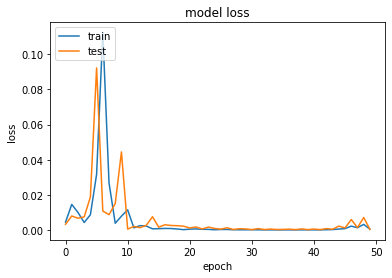

In [16]:
# Evaluate loss of model
model.evaluate(X_test, y_test)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


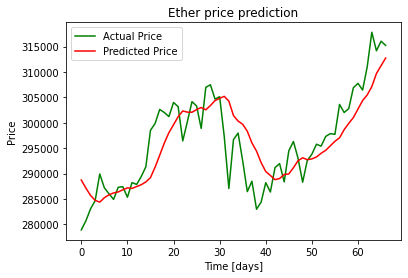

In [18]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ether price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();